In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score
from itertools import product
from sklearn.model_selection import StratifiedKFold
import optuna
import plotly.express as px
from collections import Counter

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fill_repeater_from_source(row, data):
    if pd.isna(row['Repeater']):
        same_source_rows = data[data['Source'] == row['Source']]
        non_nan_values = same_source_rows['Repeater'].dropna().unique()
        if len(non_nan_values) == 1: 
            return non_nan_values[0]
    return row['Repeater']

In [3]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)
frb_data['Repeater'] = frb_data.apply(fill_repeater_from_source, axis=1, data=frb_data)

frb_data['Repeater'].isna().sum()

np.int64(0)

In [4]:
# Select numerical columns that are relevant for VAE training
# features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_SNR_err', 'DM_alig', 'DM_alig_err', 'Flux_density', 
#             'Flux_density_err', 'Width', 'Width_err', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Fluence_err', 'Energy', 
#             'Energy_err', 'Polar_l', 'Polar_l_err', 'Polar_c', 'Polar_c_err', 'RM_syn', 'RM_syn_err', 'RM_QUfit', 'RM_QUfit_err', 'Scatt_t', 'Scatt_t_err', 'Scin_f', 'Scin_f_err',]

labels = frb_data['Repeater']

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        try:
            # Remove special characters and split if necessary
            for char in ['/', '+', '<', '>', '~']:
                value = value.replace(char, '')
            if '-' in value:
                value = value.split('-')[0]
            return float(value)
        except ValueError:
            return np.nan
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan
    
error_features = [
    'DM_SNR', 'DM_alig', 'Flux_density', 'Width', 'Fluence', 'Energy',
    'Polar_l', 'Polar_c', 'RM_syn', 'RM_QUfit', 'Scatt_t', 'Scin_f'
]
base_features = [
    'Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'Freq_high',
    'Freq_low', 'Freq_peak', 'Repeater'
]

for feature in base_features + error_features:
    frb_data[feature] = frb_data[feature].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_err'] = frb_data[f'{feature}_err'].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_upper'] = frb_data[feature] + frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[f'{feature}_lower'].clip(lower=0)

features = (
    base_features +
    error_features +
    [f'{feature}_upper' for feature in error_features] +
    [f'{feature}_lower' for feature in error_features]
)

In [5]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Retain the original indices
indices = frb_data_clean.index

# Split the data and retain indices
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()
        
        self.activation = activation
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        
        # Classification head for binary classification
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(z)
        return recon_x, mu, logvar, class_prob

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = frb_data_scaled.shape[1]
hidden_dim = 256
latent_dim = 10
stop_patience = 8
num_epochs = 150

In [8]:
reconstruction_loss_fn = nn.MSELoss(reduction='sum')
classification_loss_fn = nn.BCELoss()

def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma):
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss



In [9]:
def train_supervised(model, optimizer, scheduler, epoch, beta, gamma):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
        #     print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
        #           f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised(model, scheduler, optimizer, epoch, beta, gamma):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



In [10]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')

    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, recall, false_positives  # Return F1 score as well

def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [11]:
def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, class_report, conf_matrix, all_preds, all_labels

original_data = pd.read_csv('frb-data.csv')
original_data['Repeater'] = original_data['Repeater'].map({'Yes': 1, 'No': 0})
print(original_data['Repeater'].isna().sum())

print(f"Number of NaN values in 'Repeater' column before processing: {original_data['Repeater'].isna().sum()}")
# Apply the function row-wise
original_data['Repeater'] = original_data.apply(fill_repeater_from_source, axis=1, data=original_data)

print(f"Number of NaN values in 'Repeater' column after processing: {original_data['Repeater'].isna().sum()}")

443
Number of NaN values in 'Repeater' column before processing: 443
Number of NaN values in 'Repeater' column after processing: 0


In [12]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [99]:
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 128, 1024)
    latent_dim = trial.suggest_int('latent_dim', 5, 40)
    beta = trial.suggest_float('beta', 0.1, 2.0)
    gamma = trial.suggest_float('gamma', 0.1, 2.0)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2)
    scheduler_patience = trial.suggest_int('scheduler_patience', 2, 7)
    
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU', 'SELU', 'GELU'])
    activation = get_activation_function(activation_name)

    model = SupervisedVAE(input_dim, hidden_dim, latent_dim, dropout_rate, activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=scheduler_patience)
    
    all_false_positives = []
    all_false_negatives = []
    all_true_positives = []
    all_true_negatives = []

    num_epochs = 50

    n_folds = 5
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


    for fold, (train_index, val_index) in enumerate(skf.split(frb_data_scaled, labels)):
        # print(f"\n=== Fold {fold + 1}/{n_folds} ===")
        
        train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
        train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]
        
        train_tensor = torch.tensor(train_data, dtype=torch.float32)
        val_tensor = torch.tensor(val_data, dtype=torch.float32)
        train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
        val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)
        
        train_dataset = TensorDataset(train_tensor, train_labels_tensor)
        val_dataset = TensorDataset(val_tensor, val_labels_tensor)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        

        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
        
        # Train the model
        for epoch in range(1, num_epochs + 1):
            train_loss, _, _, _, train_accuracy = train_supervised(model, optimizer, scheduler, epoch, beta, gamma)
            val_loss, _, _, _, val_accuracy = validate_supervised(model, optimizer, scheduler, epoch, beta, gamma)
            scheduler.step(val_loss)
            
            # Early stopping
            if early_stopping([val_loss], stop_patience):
                print(f"Early stopping triggered at epoch {epoch}")
                break

        val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(model, val_loader, device)
        
        # print(f"Validation Accuracy: {val_accuracy:.4f}")
        # print("Classification Report:\n", val_class_report)
        # print("Confusion Matrix:\n", val_conf_matrix)
        
        misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
        misclassified_indices = val_index[misclassified_non_repeaters]
        misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()
        
        false_positives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 1)], "Source"]
        false_negatives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 0)], "Source"]
        true_positives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 1)], "Source"]
        true_negatives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 0)], "Source"]
        
        # fold_false_positives = []
        # for source in misclassified_sources:
        #     # fold_false_positives.append(source)
        #     if source in garcia_list or source in luo_list or source in zhu_ge_list:
        #         print(f"False positive in fold {fold + 1}: {source}")
                
        all_false_negatives.extend(false_negatives_fold)
        all_true_positives.extend(true_positives_fold)
        all_true_negatives.extend(true_negatives_fold)
        all_false_positives.extend(false_positives_fold)
        
        
    all_false_positives = pd.Series(all_false_positives)
    all_false_negatives = pd.Series(all_false_negatives)
    all_true_positives = pd.Series(all_true_positives)
    all_true_negatives = pd.Series(all_true_negatives)

    print("\n=== Summary ===")
    print(f"Total False Positives: {all_false_positives.nunique()}")
    print(f"Total False Negatives: {all_false_negatives.nunique()}")
    print(f"Total True Positives: {all_true_positives.nunique()}")
    print(f"Total True Negatives: {all_true_negatives.nunique()}")

    # Confusion matrix

    conf_mat_final = np.zeros((2, 2))
    conf_mat_final[0, 0] = all_true_negatives.nunique()
    conf_mat_final[0, 1] = all_false_positives.nunique()
    conf_mat_final[1, 0] = all_false_negatives.nunique()
    conf_mat_final[1, 1] = all_true_positives.nunique()
    conf_mat_final.astype(int)
    print(conf_mat_final)

    recall = all_true_positives.nunique() / (all_true_positives.nunique() + all_false_negatives.nunique())
    
    return recall
        
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best Hyperparameters:", study.best_params)

[I 2024-11-23 22:31:36,947] A new study created in memory with name: no-name-192c61e6-7dd5-4e3c-9b21-a7887e552451
[I 2024-11-23 22:33:15,290] Trial 0 finished with value: 0.8933333333333333 and parameters: {'hidden_dim': 169, 'latent_dim': 12, 'beta': 0.18365068798781042, 'gamma': 1.502517180914118, 'dropout_rate': 0.23601330658639436, 'lr': 0.002706840355037276, 'scheduler_patience': 5, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8933333333333333.



=== Summary ===
Total False Positives: 18
Total False Negatives: 8
Total True Positives: 67
Total True Negatives: 732
[[732.  18.]
 [  8.  67.]]


[I 2024-11-23 22:34:54,793] Trial 1 finished with value: 0.6435643564356436 and parameters: {'hidden_dim': 408, 'latent_dim': 35, 'beta': 1.4640189189336303, 'gamma': 0.23763337683080993, 'dropout_rate': 0.20891548714220015, 'lr': 0.009137856466727878, 'scheduler_patience': 5, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8933333333333333.



=== Summary ===
Total False Positives: 217
Total False Negatives: 36
Total True Positives: 65
Total True Negatives: 533
[[533. 217.]
 [ 36.  65.]]


[I 2024-11-23 22:36:43,998] Trial 2 finished with value: 0.8375 and parameters: {'hidden_dim': 1004, 'latent_dim': 34, 'beta': 0.46564582738917404, 'gamma': 0.29508234938403827, 'dropout_rate': 0.2956050132919331, 'lr': 0.0011155397782477846, 'scheduler_patience': 7, 'activation': 'ELU'}. Best is trial 0 with value: 0.8933333333333333.



=== Summary ===
Total False Positives: 47
Total False Negatives: 13
Total True Positives: 67
Total True Negatives: 703
[[703.  47.]
 [ 13.  67.]]


[I 2024-11-23 22:38:26,069] Trial 3 finished with value: 0.67 and parameters: {'hidden_dim': 557, 'latent_dim': 13, 'beta': 1.217138166038508, 'gamma': 1.8383630957871433, 'dropout_rate': 0.3806290805872754, 'lr': 0.003381127403883387, 'scheduler_patience': 6, 'activation': 'ELU'}. Best is trial 0 with value: 0.8933333333333333.



=== Summary ===
Total False Positives: 170
Total False Negatives: 33
Total True Positives: 67
Total True Negatives: 579
[[579. 170.]
 [ 33.  67.]]


[I 2024-11-23 22:40:10,010] Trial 4 finished with value: 0.7701149425287356 and parameters: {'hidden_dim': 762, 'latent_dim': 18, 'beta': 0.8932359268591451, 'gamma': 1.5570447640992777, 'dropout_rate': 0.30440162827918643, 'lr': 0.007777883664096473, 'scheduler_patience': 7, 'activation': 'GELU'}. Best is trial 0 with value: 0.8933333333333333.



=== Summary ===
Total False Positives: 54
Total False Negatives: 20
Total True Positives: 67
Total True Negatives: 696
[[696.  54.]
 [ 20.  67.]]


[I 2024-11-23 22:41:53,700] Trial 5 finished with value: 0.7613636363636364 and parameters: {'hidden_dim': 652, 'latent_dim': 38, 'beta': 1.149430367107393, 'gamma': 0.3639333436466228, 'dropout_rate': 0.15501632904026846, 'lr': 0.006593586133636479, 'scheduler_patience': 2, 'activation': 'SELU'}. Best is trial 0 with value: 0.8933333333333333.



=== Summary ===
Total False Positives: 141
Total False Negatives: 21
Total True Positives: 67
Total True Negatives: 608
[[608. 141.]
 [ 21.  67.]]


[I 2024-11-23 22:43:46,356] Trial 6 finished with value: 0.7701149425287356 and parameters: {'hidden_dim': 932, 'latent_dim': 26, 'beta': 0.7945213887892298, 'gamma': 1.7783294576241522, 'dropout_rate': 0.2695831705801224, 'lr': 0.007448545118712979, 'scheduler_patience': 4, 'activation': 'SELU'}. Best is trial 0 with value: 0.8933333333333333.



=== Summary ===
Total False Positives: 72
Total False Negatives: 20
Total True Positives: 67
Total True Negatives: 678
[[678.  72.]
 [ 20.  67.]]


[I 2024-11-23 22:45:32,610] Trial 7 finished with value: 0.6568627450980392 and parameters: {'hidden_dim': 717, 'latent_dim': 26, 'beta': 1.2832225621936153, 'gamma': 1.965661927210253, 'dropout_rate': 0.10986526212759387, 'lr': 0.004729700291416223, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.8933333333333333.



=== Summary ===
Total False Positives: 115
Total False Negatives: 35
Total True Positives: 67
Total True Negatives: 634
[[634. 115.]
 [ 35.  67.]]


[I 2024-11-23 22:47:14,580] Trial 8 finished with value: 0.8072289156626506 and parameters: {'hidden_dim': 547, 'latent_dim': 24, 'beta': 0.4738512528788349, 'gamma': 0.9158976846846211, 'dropout_rate': 0.19033010573401388, 'lr': 0.0032185746676496076, 'scheduler_patience': 2, 'activation': 'ELU'}. Best is trial 0 with value: 0.8933333333333333.



=== Summary ===
Total False Positives: 45
Total False Negatives: 16
Total True Positives: 67
Total True Negatives: 704
[[704.  45.]
 [ 16.  67.]]


[I 2024-11-23 22:48:58,912] Trial 9 finished with value: 0.9710144927536232 and parameters: {'hidden_dim': 734, 'latent_dim': 31, 'beta': 0.1051276267348451, 'gamma': 0.4629505876707247, 'dropout_rate': 0.14911092114839763, 'lr': 0.008104569439717439, 'scheduler_patience': 3, 'activation': 'GELU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 2
Total False Negatives: 2
Total True Positives: 67
Total True Negatives: 747
[[747.   2.]
 [  2.  67.]]


[I 2024-11-23 22:50:37,316] Trial 10 finished with value: 0.673469387755102 and parameters: {'hidden_dim': 321, 'latent_dim': 7, 'beta': 1.8041007491660104, 'gamma': 0.7281366681321401, 'dropout_rate': 0.47654980765106, 'lr': 0.00893771727186703, 'scheduler_patience': 3, 'activation': 'GELU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 286
Total False Negatives: 32
Total True Positives: 66
Total True Negatives: 463
[[463. 286.]
 [ 32.  66.]]


[I 2024-11-23 22:52:16,569] Trial 11 finished with value: 0.9710144927536232 and parameters: {'hidden_dim': 191, 'latent_dim': 6, 'beta': 0.11099414460032164, 'gamma': 1.3639764600549995, 'dropout_rate': 0.10434589785666212, 'lr': 0.000933245986943834, 'scheduler_patience': 4, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 16
Total False Negatives: 2
Total True Positives: 67
Total True Negatives: 732
[[732.  16.]
 [  2.  67.]]


[I 2024-11-23 22:53:51,289] Trial 12 finished with value: 0.8933333333333333 and parameters: {'hidden_dim': 133, 'latent_dim': 31, 'beta': 0.15581704452661188, 'gamma': 1.2381421790361857, 'dropout_rate': 0.10329822418488466, 'lr': 0.0003262042325180882, 'scheduler_patience': 3, 'activation': 'GELU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 5
Total False Negatives: 8
Total True Positives: 67
Total True Negatives: 743
[[743.   5.]
 [  8.  67.]]


[I 2024-11-23 22:55:37,584] Trial 13 finished with value: 0.8701298701298701 and parameters: {'hidden_dim': 852, 'latent_dim': 18, 'beta': 0.5122465161994454, 'gamma': 1.1909536060806536, 'dropout_rate': 0.15251040782971212, 'lr': 0.005891866715702505, 'scheduler_patience': 4, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 18
Total False Negatives: 10
Total True Positives: 67
Total True Negatives: 731
[[731.  18.]
 [ 10.  67.]]


[I 2024-11-23 22:57:17,888] Trial 14 finished with value: 0.8589743589743589 and parameters: {'hidden_dim': 413, 'latent_dim': 5, 'beta': 0.13470472837490705, 'gamma': 0.6640222604450757, 'dropout_rate': 0.3667335835557189, 'lr': 0.004809643013207726, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 39
Total False Negatives: 11
Total True Positives: 67
Total True Negatives: 710
[[710.  39.]
 [ 11.  67.]]


[I 2024-11-23 22:58:51,052] Trial 15 finished with value: 0.7701149425287356 and parameters: {'hidden_dim': 273, 'latent_dim': 30, 'beta': 0.6758306084543051, 'gamma': 0.5805178181067263, 'dropout_rate': 0.15291516469209399, 'lr': 0.0018779217915681384, 'scheduler_patience': 4, 'activation': 'GELU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 89
Total False Negatives: 20
Total True Positives: 67
Total True Negatives: 660
[[660.  89.]
 [ 20.  67.]]


[I 2024-11-23 23:00:31,226] Trial 16 finished with value: 0.8481012658227848 and parameters: {'hidden_dim': 482, 'latent_dim': 19, 'beta': 0.36294620363089736, 'gamma': 1.0202194318646987, 'dropout_rate': 0.10599860684850057, 'lr': 0.00953774783997436, 'scheduler_patience': 3, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 13
Total False Negatives: 12
Total True Positives: 67
Total True Negatives: 736
[[736.  13.]
 [ 12.  67.]]


[I 2024-11-23 23:02:18,060] Trial 17 finished with value: 0.7052631578947368 and parameters: {'hidden_dim': 845, 'latent_dim': 40, 'beta': 1.8839033938065648, 'gamma': 1.4095374337225184, 'dropout_rate': 0.20073641273594328, 'lr': 0.007854082949381955, 'scheduler_patience': 2, 'activation': 'GELU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 137
Total False Negatives: 28
Total True Positives: 67
Total True Negatives: 613
[[613. 137.]
 [ 28.  67.]]


[I 2024-11-23 23:03:59,947] Trial 18 finished with value: 0.9436619718309859 and parameters: {'hidden_dim': 607, 'latent_dim': 11, 'beta': 0.3330506837310027, 'gamma': 0.8764130828441002, 'dropout_rate': 0.4972916629316827, 'lr': 0.004214469792625206, 'scheduler_patience': 6, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 36
Total False Negatives: 4
Total True Positives: 67
Total True Negatives: 714
[[714.  36.]
 [  4.  67.]]


[I 2024-11-23 23:05:36,458] Trial 19 finished with value: 0.7204301075268817 and parameters: {'hidden_dim': 230, 'latent_dim': 29, 'beta': 0.7194451796651506, 'gamma': 0.5231548515058926, 'dropout_rate': 0.14683773433252162, 'lr': 0.0062609083849455155, 'scheduler_patience': 4, 'activation': 'SELU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 97
Total False Negatives: 26
Total True Positives: 67
Total True Negatives: 652
[[652.  97.]
 [ 26.  67.]]


[I 2024-11-23 23:07:19,059] Trial 20 finished with value: 0.7096774193548387 and parameters: {'hidden_dim': 710, 'latent_dim': 21, 'beta': 0.9364943384035681, 'gamma': 0.11013017261524644, 'dropout_rate': 0.2501394820598611, 'lr': 0.002005622466288104, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 103
Total False Negatives: 27
Total True Positives: 66
Total True Negatives: 646
[[646. 103.]
 [ 27.  66.]]


[I 2024-11-23 23:08:58,234] Trial 21 finished with value: 0.7528089887640449 and parameters: {'hidden_dim': 630, 'latent_dim': 10, 'beta': 0.3374645491950654, 'gamma': 0.7988948495325219, 'dropout_rate': 0.4899500070698609, 'lr': 0.004155131754555068, 'scheduler_patience': 6, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 45
Total False Negatives: 22
Total True Positives: 67
Total True Negatives: 704
[[704.  45.]
 [ 22.  67.]]


[I 2024-11-23 23:10:43,697] Trial 22 finished with value: 0.868421052631579 and parameters: {'hidden_dim': 795, 'latent_dim': 15, 'beta': 0.3021962144599391, 'gamma': 1.1938276792592575, 'dropout_rate': 0.3992919141382082, 'lr': 0.00030284961341439653, 'scheduler_patience': 6, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 27
Total False Negatives: 10
Total True Positives: 66
Total True Negatives: 722
[[722.  27.]
 [ 10.  66.]]


[I 2024-11-23 23:12:19,623] Trial 23 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 472, 'latent_dim': 8, 'beta': 0.10878640907897223, 'gamma': 0.9437609190826175, 'dropout_rate': 0.4369187843927847, 'lr': 0.0053298924951634945, 'scheduler_patience': 5, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 22
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 726
[[726.  22.]
 [  6.  67.]]


[I 2024-11-23 23:14:01,310] Trial 24 finished with value: 0.8375 and parameters: {'hidden_dim': 620, 'latent_dim': 5, 'beta': 0.5815898592382214, 'gamma': 0.42137538764854304, 'dropout_rate': 0.34197609390136485, 'lr': 0.003730465604588581, 'scheduler_patience': 6, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 64
Total False Negatives: 13
Total True Positives: 67
Total True Negatives: 686
[[686.  64.]
 [ 13.  67.]]


[I 2024-11-23 23:15:45,718] Trial 25 finished with value: 0.8589743589743589 and parameters: {'hidden_dim': 697, 'latent_dim': 10, 'beta': 0.3097166661005536, 'gamma': 1.3444593342243536, 'dropout_rate': 0.4330891194531934, 'lr': 0.007068422151842927, 'scheduler_patience': 4, 'activation': 'GELU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 17
Total False Negatives: 11
Total True Positives: 67
Total True Negatives: 732
[[732.  17.]
 [ 11.  67.]]


[I 2024-11-23 23:17:26,473] Trial 26 finished with value: 0.8375 and parameters: {'hidden_dim': 346, 'latent_dim': 15, 'beta': 0.2887476382727096, 'gamma': 0.8811439627452675, 'dropout_rate': 0.3333737894605918, 'lr': 0.008447407009145015, 'scheduler_patience': 7, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 28
Total False Negatives: 13
Total True Positives: 67
Total True Negatives: 721
[[721.  28.]
 [ 13.  67.]]


[I 2024-11-23 23:19:07,665] Trial 27 finished with value: 0.6504854368932039 and parameters: {'hidden_dim': 511, 'latent_dim': 8, 'beta': 1.5865694816741847, 'gamma': 1.6444122484064705, 'dropout_rate': 0.18451724479209589, 'lr': 0.0018169539763386415, 'scheduler_patience': 5, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 159
Total False Negatives: 36
Total True Positives: 67
Total True Negatives: 590
[[590. 159.]
 [ 36.  67.]]


[I 2024-11-23 23:20:52,257] Trial 28 finished with value: 0.7444444444444445 and parameters: {'hidden_dim': 908, 'latent_dim': 33, 'beta': 0.5489132935827632, 'gamma': 1.0951440631053149, 'dropout_rate': 0.43114488668647344, 'lr': 0.009874858064102439, 'scheduler_patience': 3, 'activation': 'GELU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 54
Total False Negatives: 23
Total True Positives: 67
Total True Negatives: 696
[[696.  54.]
 [ 23.  67.]]


[I 2024-11-23 23:22:33,155] Trial 29 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 618, 'latent_dim': 13, 'beta': 0.23719385761797526, 'gamma': 0.5177401831820866, 'dropout_rate': 0.24145694546102747, 'lr': 0.0028473973581440086, 'scheduler_patience': 5, 'activation': 'ReLU'}. Best is trial 9 with value: 0.9710144927536232.



=== Summary ===
Total False Positives: 5
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 743
[[743.   5.]
 [  6.  67.]]


[I 2024-11-23 23:24:05,441] Trial 30 finished with value: 1.0 and parameters: {'hidden_dim': 405, 'latent_dim': 11, 'beta': 0.10453404864734217, 'gamma': 1.3960807030216977, 'dropout_rate': 0.12965067778016798, 'lr': 0.00435761006480159, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 1
Total False Negatives: 0
Total True Positives: 67
Total True Negatives: 747
[[747.   1.]
 [  0.  67.]]


[I 2024-11-23 23:25:37,721] Trial 31 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 209, 'latent_dim': 11, 'beta': 0.1273475779813453, 'gamma': 1.4335001691318945, 'dropout_rate': 0.12538045475761753, 'lr': 0.00416585588349118, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 1
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 747
[[747.   1.]
 [  1.  67.]]


[I 2024-11-23 23:27:09,815] Trial 32 finished with value: 0.9571428571428572 and parameters: {'hidden_dim': 197, 'latent_dim': 15, 'beta': 0.10593486448924429, 'gamma': 1.46714475457737, 'dropout_rate': 0.13167139373816583, 'lr': 0.005471724896293088, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 2
Total False Negatives: 3
Total True Positives: 67
Total True Negatives: 746
[[746.   2.]
 [  3.  67.]]


[I 2024-11-23 23:28:47,423] Trial 33 finished with value: 0.8701298701298701 and parameters: {'hidden_dim': 266, 'latent_dim': 7, 'beta': 0.4014211193847758, 'gamma': 1.6588765479973087, 'dropout_rate': 0.17144517086464678, 'lr': 0.002461804823870232, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 51
Total False Negatives: 10
Total True Positives: 67
Total True Negatives: 699
[[699.  51.]
 [ 10.  67.]]


[I 2024-11-23 23:30:23,851] Trial 34 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 386, 'latent_dim': 36, 'beta': 0.21074067239637362, 'gamma': 1.3216749259244498, 'dropout_rate': 0.2155733636514971, 'lr': 0.001022726507345727, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 12
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 737
[[737.  12.]
 [  6.  67.]]


[I 2024-11-23 23:31:57,709] Trial 35 finished with value: 0.8933333333333333 and parameters: {'hidden_dim': 132, 'latent_dim': 12, 'beta': 0.2226062566990735, 'gamma': 1.5627401539504862, 'dropout_rate': 0.1314452116003189, 'lr': 0.0041767859494245135, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 18
Total False Negatives: 8
Total True Positives: 67
Total True Negatives: 731
[[731.  18.]
 [  8.  67.]]


[I 2024-11-23 23:33:34,012] Trial 36 finished with value: 0.8170731707317073 and parameters: {'hidden_dim': 194, 'latent_dim': 21, 'beta': 0.47015860020401434, 'gamma': 1.1005304594139473, 'dropout_rate': 0.12750794284423603, 'lr': 0.0010593263065962427, 'scheduler_patience': 5, 'activation': 'ELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 44
Total False Negatives: 15
Total True Positives: 67
Total True Negatives: 705
[[705.  44.]
 [ 15.  67.]]


[I 2024-11-23 23:35:09,716] Trial 37 finished with value: 0.8072289156626506 and parameters: {'hidden_dim': 306, 'latent_dim': 9, 'beta': 0.6208563364207457, 'gamma': 1.7469055713783017, 'dropout_rate': 0.22361196162937824, 'lr': 0.006753621212636916, 'scheduler_patience': 2, 'activation': 'SELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 109
Total False Negatives: 16
Total True Positives: 67
Total True Negatives: 640
[[640. 109.]
 [ 16.  67.]]


[I 2024-11-23 23:36:49,089] Trial 38 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 442, 'latent_dim': 17, 'beta': 0.20436464444278363, 'gamma': 1.482534764507466, 'dropout_rate': 0.17475886014179334, 'lr': 0.0037338808975786587, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 2
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 746
[[746.   2.]
 [  1.  67.]]


[I 2024-11-23 23:38:28,366] Trial 39 finished with value: 0.7052631578947368 and parameters: {'hidden_dim': 440, 'latent_dim': 16, 'beta': 1.024601946100354, 'gamma': 1.9720539505683512, 'dropout_rate': 0.17851856439987918, 'lr': 0.004643272181640925, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 82
Total False Negatives: 28
Total True Positives: 67
Total True Negatives: 667
[[667.  82.]
 [ 28.  67.]]


[I 2024-11-23 23:40:08,078] Trial 40 finished with value: 0.673469387755102 and parameters: {'hidden_dim': 541, 'latent_dim': 17, 'beta': 1.4034897839337768, 'gamma': 1.5117042858379537, 'dropout_rate': 0.2799319362629948, 'lr': 0.00345434480982013, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 133
Total False Negatives: 32
Total True Positives: 66
Total True Negatives: 617
[[617. 133.]
 [ 32.  66.]]


[I 2024-11-23 23:41:44,770] Trial 41 finished with value: 0.9571428571428572 and parameters: {'hidden_dim': 360, 'latent_dim': 13, 'beta': 0.21965853839983168, 'gamma': 1.3566899168911137, 'dropout_rate': 0.12349320211945809, 'lr': 0.0057556600614559784, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 4
Total False Negatives: 3
Total True Positives: 67
Total True Negatives: 744
[[744.   4.]
 [  3.  67.]]


[I 2024-11-23 23:43:24,759] Trial 42 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 244, 'latent_dim': 25, 'beta': 0.10761690381655493, 'gamma': 1.2662320653414978, 'dropout_rate': 0.16272637264010212, 'lr': 0.002685620210673859, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 4
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 744
[[744.   4.]
 [  1.  67.]]


[I 2024-11-23 23:45:01,489] Trial 43 finished with value: 0.8170731707317073 and parameters: {'hidden_dim': 260, 'latent_dim': 27, 'beta': 0.43587003240251954, 'gamma': 1.2619409596304667, 'dropout_rate': 0.16429028791536124, 'lr': 0.002630894699534669, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 39
Total False Negatives: 15
Total True Positives: 67
Total True Negatives: 710
[[710.  39.]
 [ 15.  67.]]


[I 2024-11-23 23:46:39,667] Trial 44 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 324, 'latent_dim': 24, 'beta': 0.2014390583743283, 'gamma': 1.4478692823452453, 'dropout_rate': 0.1967758222313118, 'lr': 0.0037197161952886386, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 6
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 743
[[743.   6.]
 [  6.  67.]]


[I 2024-11-23 23:48:16,922] Trial 45 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 428, 'latent_dim': 20, 'beta': 0.10139977075521661, 'gamma': 1.612892166897792, 'dropout_rate': 0.1417320958399615, 'lr': 0.00468619595240478, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 0
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 748
[[748.   0.]
 [  1.  67.]]


[I 2024-11-23 23:49:56,115] Trial 46 finished with value: 0.8589743589743589 and parameters: {'hidden_dim': 400, 'latent_dim': 21, 'beta': 0.4091063928008707, 'gamma': 1.863649238606397, 'dropout_rate': 0.13395711421054957, 'lr': 0.002955442634757015, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 16
Total False Negatives: 11
Total True Positives: 67
Total True Negatives: 733
[[733.  16.]
 [ 11.  67.]]


[I 2024-11-23 23:51:34,520] Trial 47 finished with value: 0.9571428571428572 and parameters: {'hidden_dim': 448, 'latent_dim': 19, 'beta': 0.19817919303605958, 'gamma': 1.5838195331156881, 'dropout_rate': 0.16736304696754656, 'lr': 0.004681862452075775, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 1
Total False Negatives: 3
Total True Positives: 67
Total True Negatives: 748
[[748.   1.]
 [  3.  67.]]


[I 2024-11-23 23:53:09,553] Trial 48 finished with value: 0.7701149425287356 and parameters: {'hidden_dim': 233, 'latent_dim': 23, 'beta': 0.8036165027534762, 'gamma': 1.6884743189126863, 'dropout_rate': 0.11686535200635273, 'lr': 0.0037441499828478873, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 105
Total False Negatives: 20
Total True Positives: 67
Total True Negatives: 645
[[645. 105.]
 [ 20.  67.]]


[I 2024-11-23 23:54:48,732] Trial 49 finished with value: 0.9305555555555556 and parameters: {'hidden_dim': 371, 'latent_dim': 27, 'beta': 0.26732372084050676, 'gamma': 1.7734786252169654, 'dropout_rate': 0.14091726147088893, 'lr': 0.0022533283512886043, 'scheduler_patience': 5, 'activation': 'ELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 7
Total False Negatives: 5
Total True Positives: 67
Total True Negatives: 742
[[742.   7.]
 [  5.  67.]]


[I 2024-11-23 23:56:27,770] Trial 50 finished with value: 0.9571428571428572 and parameters: {'hidden_dim': 301, 'latent_dim': 19, 'beta': 0.1682481881521169, 'gamma': 1.2758595107447088, 'dropout_rate': 0.2159512647113504, 'lr': 0.005133378766790481, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 4
Total False Negatives: 3
Total True Positives: 67
Total True Negatives: 744
[[744.   4.]
 [  3.  67.]]


[I 2024-11-23 23:58:20,006] Trial 51 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 1013, 'latent_dim': 25, 'beta': 0.10786162825725898, 'gamma': 1.442591549097069, 'dropout_rate': 0.15342952533573462, 'lr': 0.004342281640112358, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 1
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 747
[[747.   1.]
 [  1.  67.]]


[I 2024-11-24 00:00:11,108] Trial 52 finished with value: 0.9710144927536232 and parameters: {'hidden_dim': 1006, 'latent_dim': 25, 'beta': 0.1040356705992328, 'gamma': 1.4717698427252865, 'dropout_rate': 0.15946621511363834, 'lr': 0.0032753167181125272, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 4
Total False Negatives: 2
Total True Positives: 67
Total True Negatives: 744
[[744.   4.]
 [  2.  67.]]


[I 2024-11-24 00:01:49,108] Trial 53 finished with value: 0.9571428571428572 and parameters: {'hidden_dim': 576, 'latent_dim': 22, 'beta': 0.1750079450736848, 'gamma': 1.4073639879241153, 'dropout_rate': 0.10242654508526448, 'lr': 0.004443376530738153, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 1
Total False Negatives: 3
Total True Positives: 67
Total True Negatives: 747
[[747.   1.]
 [  3.  67.]]


[I 2024-11-24 00:03:30,289] Trial 54 finished with value: 0.8701298701298701 and parameters: {'hidden_dim': 521, 'latent_dim': 28, 'beta': 0.3659753478492468, 'gamma': 1.5803243530409605, 'dropout_rate': 0.18563548715419403, 'lr': 0.005021441323083093, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 14
Total False Negatives: 10
Total True Positives: 67
Total True Negatives: 735
[[735.  14.]
 [ 10.  67.]]


[I 2024-11-24 00:05:04,668] Trial 55 finished with value: 0.8375 and parameters: {'hidden_dim': 165, 'latent_dim': 23, 'beta': 0.28562451018374346, 'gamma': 1.16239503247213, 'dropout_rate': 0.1486829539303978, 'lr': 0.00384613859247934, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 25
Total False Negatives: 13
Total True Positives: 67
Total True Negatives: 725
[[725.  25.]
 [ 13.  67.]]


[I 2024-11-24 00:06:40,725] Trial 56 finished with value: 0.9710144927536232 and parameters: {'hidden_dim': 430, 'latent_dim': 25, 'beta': 0.15585930620799215, 'gamma': 1.8498584784427454, 'dropout_rate': 0.11937666666991735, 'lr': 0.0031290385070387528, 'scheduler_patience': 4, 'activation': 'SELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 5
Total False Negatives: 2
Total True Positives: 67
Total True Negatives: 744
[[744.   5.]
 [  2.  67.]]


[I 2024-11-24 00:08:23,208] Trial 57 finished with value: 0.8375 and parameters: {'hidden_dim': 671, 'latent_dim': 20, 'beta': 0.4845908577517324, 'gamma': 1.5156503650184836, 'dropout_rate': 0.19877206571625539, 'lr': 0.005937920812374337, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 25
Total False Negatives: 13
Total True Positives: 67
Total True Negatives: 724
[[724.  25.]
 [ 13.  67.]]


[I 2024-11-24 00:10:02,514] Trial 58 finished with value: 0.6842105263157895 and parameters: {'hidden_dim': 486, 'latent_dim': 13, 'beta': 1.167303733410103, 'gamma': 1.3976741832948378, 'dropout_rate': 0.17490441986631378, 'lr': 0.0043553774138158875, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 110
Total False Negatives: 30
Total True Positives: 65
Total True Negatives: 640
[[640. 110.]
 [ 30.  65.]]


[I 2024-11-24 00:11:45,152] Trial 59 finished with value: 0.6285714285714286 and parameters: {'hidden_dim': 578, 'latent_dim': 17, 'beta': 1.6777677695871125, 'gamma': 1.2904320967428466, 'dropout_rate': 0.2540589370240241, 'lr': 0.003493511058462677, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 159
Total False Negatives: 39
Total True Positives: 66
Total True Negatives: 590
[[590. 159.]
 [ 39.  66.]]


[I 2024-11-24 00:13:23,436] Trial 60 finished with value: 0.8933333333333333 and parameters: {'hidden_dim': 240, 'latent_dim': 25, 'beta': 0.35500104578723113, 'gamma': 1.619517334441049, 'dropout_rate': 0.1433911587832116, 'lr': 0.004071370261144319, 'scheduler_patience': 4, 'activation': 'ELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 30
Total False Negatives: 8
Total True Positives: 67
Total True Negatives: 719
[[719.  30.]
 [  8.  67.]]


[I 2024-11-24 00:15:13,498] Trial 61 finished with value: 0.9710144927536232 and parameters: {'hidden_dim': 932, 'latent_dim': 31, 'beta': 0.1075358983148703, 'gamma': 0.29300695369467955, 'dropout_rate': 0.15752084339300848, 'lr': 0.004936735792252092, 'scheduler_patience': 2, 'activation': 'GELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 0
Total False Negatives: 2
Total True Positives: 67
Total True Negatives: 748
[[748.   0.]
 [  2.  67.]]


[I 2024-11-24 00:16:59,749] Trial 62 finished with value: 0.9305555555555556 and parameters: {'hidden_dim': 754, 'latent_dim': 31, 'beta': 0.2576127185468224, 'gamma': 1.007829105360103, 'dropout_rate': 0.11332162492551703, 'lr': 0.0014682633670487185, 'scheduler_patience': 3, 'activation': 'GELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 5
Total False Negatives: 5
Total True Positives: 67
Total True Negatives: 744
[[744.   5.]
 [  5.  67.]]


[I 2024-11-24 00:18:45,129] Trial 63 finished with value: 0.9436619718309859 and parameters: {'hidden_dim': 845, 'latent_dim': 33, 'beta': 0.169006166861849, 'gamma': 1.213477129982599, 'dropout_rate': 0.15686082283391262, 'lr': 0.0054183075358584225, 'scheduler_patience': 4, 'activation': 'GELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 3
Total False Negatives: 4
Total True Positives: 67
Total True Negatives: 745
[[745.   3.]
 [  4.  67.]]


[I 2024-11-24 00:20:19,767] Trial 64 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 338, 'latent_dim': 29, 'beta': 0.10052408702110327, 'gamma': 1.5241986319298337, 'dropout_rate': 0.14244553548258315, 'lr': 0.008515198965878367, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 0
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 748
[[748.   0.]
 [  1.  67.]]


[I 2024-11-24 00:21:57,198] Trial 65 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 344, 'latent_dim': 28, 'beta': 0.2595391864885425, 'gamma': 1.7147094900037287, 'dropout_rate': 0.10116014210584048, 'lr': 0.006248667974504286, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 2
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 746
[[746.   2.]
 [  6.  67.]]


[I 2024-11-24 00:23:35,576] Trial 66 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 284, 'latent_dim': 29, 'beta': 0.10030355545793368, 'gamma': 1.5328400861517182, 'dropout_rate': 0.14146160625181498, 'lr': 0.008777457060876794, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 1
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 747
[[747.   1.]
 [  1.  67.]]


[I 2024-11-24 00:25:11,269] Trial 67 finished with value: 0.8375 and parameters: {'hidden_dim': 163, 'latent_dim': 11, 'beta': 0.3307920610104662, 'gamma': 1.451948357184655, 'dropout_rate': 0.18925854563959263, 'lr': 0.004547947317176125, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 17
Total False Negatives: 13
Total True Positives: 67
Total True Negatives: 732
[[732.  17.]
 [ 13.  67.]]


[I 2024-11-24 00:26:51,463] Trial 68 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 467, 'latent_dim': 26, 'beta': 0.16854926494881553, 'gamma': 1.3856441585217418, 'dropout_rate': 0.2049907790053255, 'lr': 0.003986101238563354, 'scheduler_patience': 6, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 0
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 748
[[748.   0.]
 [  6.  67.]]


[I 2024-11-24 00:28:26,656] Trial 69 finished with value: 0.8072289156626506 and parameters: {'hidden_dim': 326, 'latent_dim': 22, 'beta': 0.38778218141700443, 'gamma': 1.132249314960543, 'dropout_rate': 0.11872287954346548, 'lr': 0.002998429828085028, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 17
Total False Negatives: 16
Total True Positives: 67
Total True Negatives: 732
[[732.  17.]
 [ 16.  67.]]


[I 2024-11-24 00:30:06,789] Trial 70 finished with value: 0.9305555555555556 and parameters: {'hidden_dim': 411, 'latent_dim': 24, 'beta': 0.25474119408762286, 'gamma': 1.6210758533039467, 'dropout_rate': 0.17336091455134697, 'lr': 0.007440971439632666, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 5
Total False Negatives: 5
Total True Positives: 67
Total True Negatives: 744
[[744.   5.]
 [  5.  67.]]


[I 2024-11-24 00:31:42,964] Trial 71 finished with value: 0.9571428571428572 and parameters: {'hidden_dim': 214, 'latent_dim': 30, 'beta': 0.14600630854705265, 'gamma': 1.523273885779839, 'dropout_rate': 0.1411542606207644, 'lr': 0.008885184368453463, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 6
Total False Negatives: 3
Total True Positives: 67
Total True Negatives: 742
[[742.   6.]
 [  3.  67.]]


[I 2024-11-24 00:33:19,222] Trial 72 finished with value: 1.0 and parameters: {'hidden_dim': 282, 'latent_dim': 29, 'beta': 0.11601385172101958, 'gamma': 1.3222748790745873, 'dropout_rate': 0.13666196729471, 'lr': 0.008420520735079986, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 1
Total False Negatives: 0
Total True Positives: 67
Total True Negatives: 747
[[747.   1.]
 [  0.  67.]]


[I 2024-11-24 00:34:54,435] Trial 73 finished with value: 0.9305555555555556 and parameters: {'hidden_dim': 383, 'latent_dim': 14, 'beta': 0.20882742552372352, 'gamma': 1.3556096738527825, 'dropout_rate': 0.13461355467174646, 'lr': 0.009323469994127953, 'scheduler_patience': 4, 'activation': 'SELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 6
Total False Negatives: 5
Total True Positives: 67
Total True Negatives: 743
[[743.   6.]
 [  5.  67.]]


[I 2024-11-24 00:36:33,641] Trial 74 finished with value: 0.8481012658227848 and parameters: {'hidden_dim': 297, 'latent_dim': 33, 'beta': 0.3133542281935898, 'gamma': 1.3273549618867295, 'dropout_rate': 0.15319281041074118, 'lr': 0.008404943527996403, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 32
Total False Negatives: 12
Total True Positives: 67
Total True Negatives: 717
[[717.  32.]
 [ 12.  67.]]


[I 2024-11-24 00:38:11,020] Trial 75 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 248, 'latent_dim': 27, 'beta': 0.1611094535932625, 'gamma': 1.453334631178449, 'dropout_rate': 0.1241732879699345, 'lr': 0.007559744825859102, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 7
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 742
[[742.   7.]
 [  1.  67.]]


[I 2024-11-24 00:39:50,640] Trial 76 finished with value: 0.6875 and parameters: {'hidden_dim': 345, 'latent_dim': 36, 'beta': 1.3098346491600525, 'gamma': 1.2171721203269394, 'dropout_rate': 0.3170630683920446, 'lr': 0.008032550499828199, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 222
Total False Negatives: 30
Total True Positives: 66
Total True Negatives: 528
[[528. 222.]
 [ 30.  66.]]


[I 2024-11-24 00:41:24,639] Trial 77 finished with value: 0.9054054054054054 and parameters: {'hidden_dim': 279, 'latent_dim': 11, 'beta': 0.21743396974117157, 'gamma': 1.2857534952049523, 'dropout_rate': 0.1649898809815603, 'lr': 0.003596944522399012, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 17
Total False Negatives: 7
Total True Positives: 67
Total True Negatives: 732
[[732.  17.]
 [  7.  67.]]


[I 2024-11-24 00:43:04,706] Trial 78 finished with value: 0.9710144927536232 and parameters: {'hidden_dim': 508, 'latent_dim': 29, 'beta': 0.14086468599249438, 'gamma': 1.9098663964695475, 'dropout_rate': 0.1103649801972099, 'lr': 0.005174224251795924, 'scheduler_patience': 2, 'activation': 'ELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 1
Total False Negatives: 2
Total True Positives: 67
Total True Negatives: 748
[[748.   1.]
 [  2.  67.]]


[I 2024-11-24 00:44:42,812] Trial 79 finished with value: 0.9305555555555556 and parameters: {'hidden_dim': 203, 'latent_dim': 9, 'beta': 0.24374902052090486, 'gamma': 1.5959495300580813, 'dropout_rate': 0.13046170764402895, 'lr': 0.0043321768620796005, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 11
Total False Negatives: 5
Total True Positives: 67
Total True Negatives: 737
[[737.  11.]
 [  5.  67.]]


[I 2024-11-24 00:46:18,945] Trial 80 finished with value: 0.63 and parameters: {'hidden_dim': 425, 'latent_dim': 18, 'beta': 1.9799397358964543, 'gamma': 1.6697260495360131, 'dropout_rate': 0.14884222948594156, 'lr': 0.009929785507210319, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 211
Total False Negatives: 37
Total True Positives: 63
Total True Negatives: 539
[[539. 211.]
 [ 37.  63.]]


[I 2024-11-24 00:47:53,986] Trial 81 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 279, 'latent_dim': 29, 'beta': 0.13249465092752527, 'gamma': 1.5369111266879376, 'dropout_rate': 0.14092408961841243, 'lr': 0.008864120392337664, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 3
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 745
[[745.   3.]
 [  1.  67.]]


[I 2024-11-24 00:49:27,177] Trial 82 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 286, 'latent_dim': 26, 'beta': 0.10128663964834958, 'gamma': 1.4625700832034336, 'dropout_rate': 0.1798702832623376, 'lr': 0.008531728952564979, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 0
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 748
[[748.   0.]
 [  1.  67.]]


[I 2024-11-24 00:51:00,405] Trial 83 finished with value: 0.9571428571428572 and parameters: {'hidden_dim': 323, 'latent_dim': 30, 'beta': 0.1051434754460524, 'gamma': 1.4169568508083634, 'dropout_rate': 0.1645658727128772, 'lr': 0.008552204109693932, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 2
Total False Negatives: 3
Total True Positives: 67
Total True Negatives: 746
[[746.   2.]
 [  3.  67.]]


[I 2024-11-24 00:52:40,036] Trial 84 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 394, 'latent_dim': 32, 'beta': 0.19946284530798664, 'gamma': 1.5461345345130362, 'dropout_rate': 0.1369431331107551, 'lr': 0.009497199713047478, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 3
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 746
[[746.   3.]
 [  6.  67.]]


[I 2024-11-24 00:54:16,555] Trial 85 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 363, 'latent_dim': 29, 'beta': 0.29961455587256147, 'gamma': 1.4913361502758318, 'dropout_rate': 0.11224876263748246, 'lr': 0.009120671800550853, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 11
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 738
[[738.  11.]
 [  6.  67.]]


[I 2024-11-24 00:55:49,792] Trial 86 finished with value: 0.9436619718309859 and parameters: {'hidden_dim': 259, 'latent_dim': 20, 'beta': 0.1855540019384042, 'gamma': 1.739326351047542, 'dropout_rate': 0.23021587715915648, 'lr': 0.004723575744056417, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 2
Total False Negatives: 4
Total True Positives: 67
Total True Negatives: 746
[[746.   2.]
 [  4.  67.]]


[I 2024-11-24 00:57:24,382] Trial 87 finished with value: 0.8933333333333333 and parameters: {'hidden_dim': 218, 'latent_dim': 23, 'beta': 0.2798714164703128, 'gamma': 1.3144588675557336, 'dropout_rate': 0.12771843231640748, 'lr': 0.007085373071336074, 'scheduler_patience': 3, 'activation': 'SELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 11
Total False Negatives: 8
Total True Positives: 67
Total True Negatives: 739
[[739.  11.]
 [  8.  67.]]


[I 2024-11-24 00:59:02,953] Trial 88 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 463, 'latent_dim': 28, 'beta': 0.4279643305672043, 'gamma': 1.4164021256932735, 'dropout_rate': 0.14518490511118917, 'lr': 0.0026850738263210845, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 10
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 739
[[739.  10.]
 [  6.  67.]]


[I 2024-11-24 01:00:35,694] Trial 89 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 177, 'latent_dim': 16, 'beta': 0.23387186849892677, 'gamma': 1.2497060918187781, 'dropout_rate': 0.15525935846835515, 'lr': 0.004128046073400608, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 9
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 739
[[739.   9.]
 [  6.  67.]]


[I 2024-11-24 01:02:13,373] Trial 90 finished with value: 0.8933333333333333 and parameters: {'hidden_dim': 307, 'latent_dim': 6, 'beta': 0.14927184077622413, 'gamma': 1.3719404153326196, 'dropout_rate': 0.1907950723124802, 'lr': 0.0022210285818899346, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 34
Total False Negatives: 8
Total True Positives: 67
Total True Negatives: 715
[[715.  34.]
 [  8.  67.]]


[I 2024-11-24 01:03:49,695] Trial 91 finished with value: 0.9852941176470589 and parameters: {'hidden_dim': 254, 'latent_dim': 27, 'beta': 0.1021953843341529, 'gamma': 1.4997803574917297, 'dropout_rate': 0.11970420807827131, 'lr': 0.007654677805352619, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 3
Total False Negatives: 1
Total True Positives: 67
Total True Negatives: 746
[[746.   3.]
 [  1.  67.]]


[I 2024-11-24 01:05:24,887] Trial 92 finished with value: 0.9436619718309859 and parameters: {'hidden_dim': 244, 'latent_dim': 27, 'beta': 0.15582318655566793, 'gamma': 1.4336930157240455, 'dropout_rate': 0.12755824448215297, 'lr': 0.00796448522097549, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 7
Total False Negatives: 4
Total True Positives: 67
Total True Negatives: 741
[[741.   7.]
 [  4.  67.]]


[I 2024-11-24 01:06:54,618] Trial 93 finished with value: 0.881578947368421 and parameters: {'hidden_dim': 142, 'latent_dim': 25, 'beta': 0.1903175411224533, 'gamma': 1.5713619854343512, 'dropout_rate': 0.1224868411902357, 'lr': 0.008644617532039949, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 13
Total False Negatives: 9
Total True Positives: 67
Total True Negatives: 736
[[736.  13.]
 [  9.  67.]]


[I 2024-11-24 01:08:30,832] Trial 94 finished with value: 0.9305555555555556 and parameters: {'hidden_dim': 220, 'latent_dim': 26, 'beta': 0.14588333931857084, 'gamma': 1.809226877797936, 'dropout_rate': 0.10728243335462835, 'lr': 0.00826908100473912, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 14
Total False Negatives: 5
Total True Positives: 67
Total True Negatives: 735
[[735.  14.]
 [  5.  67.]]


[I 2024-11-24 01:10:08,200] Trial 95 finished with value: 0.9054054054054054 and parameters: {'hidden_dim': 342, 'latent_dim': 24, 'beta': 0.33492878929129316, 'gamma': 1.4785687210961638, 'dropout_rate': 0.16986561367989206, 'lr': 0.0007218407507184354, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 21
Total False Negatives: 7
Total True Positives: 67
Total True Negatives: 728
[[728.  21.]
 [  7.  67.]]


[I 2024-11-24 01:11:53,652] Trial 96 finished with value: 0.9571428571428572 and parameters: {'hidden_dim': 805, 'latent_dim': 28, 'beta': 0.2293853096863168, 'gamma': 1.6283538713150165, 'dropout_rate': 0.14961859304121294, 'lr': 0.005668708820057196, 'scheduler_patience': 4, 'activation': 'ELU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 10
Total False Negatives: 3
Total True Positives: 67
Total True Negatives: 739
[[739.  10.]
 [  3.  67.]]


[I 2024-11-24 01:13:28,570] Trial 97 finished with value: 0.7127659574468085 and parameters: {'hidden_dim': 378, 'latent_dim': 12, 'beta': 1.0059904149838685, 'gamma': 1.698604639157498, 'dropout_rate': 0.1372625009413679, 'lr': 0.003899363698008359, 'scheduler_patience': 3, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 85
Total False Negatives: 27
Total True Positives: 67
Total True Negatives: 665
[[665.  85.]
 [ 27.  67.]]


[I 2024-11-24 01:15:05,147] Trial 98 finished with value: 0.7976190476190477 and parameters: {'hidden_dim': 307, 'latent_dim': 32, 'beta': 0.2861788990761215, 'gamma': 1.3231521553157088, 'dropout_rate': 0.37499951287474914, 'lr': 0.007682501263559507, 'scheduler_patience': 7, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 40
Total False Negatives: 17
Total True Positives: 67
Total True Negatives: 709
[[709.  40.]
 [ 17.  67.]]


[I 2024-11-24 01:16:53,571] Trial 99 finished with value: 0.9178082191780822 and parameters: {'hidden_dim': 937, 'latent_dim': 21, 'beta': 0.18190611717413752, 'gamma': 1.4394131700602781, 'dropout_rate': 0.18034938793018504, 'lr': 0.00482094076839932, 'scheduler_patience': 5, 'activation': 'LeakyReLU'}. Best is trial 30 with value: 1.0.



=== Summary ===
Total False Positives: 6
Total False Negatives: 6
Total True Positives: 67
Total True Negatives: 743
[[743.   6.]
 [  6.  67.]]
Best Hyperparameters: {'hidden_dim': 405, 'latent_dim': 11, 'beta': 0.10453404864734217, 'gamma': 1.3960807030216977, 'dropout_rate': 0.12965067778016798, 'lr': 0.00435761006480159, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}


In [13]:
# best_params = study.best_params
best_params = {'hidden_dim': 405, 'latent_dim': 11, 'beta': 0.10453404864734217, 'gamma': 1.3960807030216977, 'dropout_rate': 0.12965067778016798, 'lr': 0.00435761006480159, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}
beta = best_params["beta"]
gamma = best_params["gamma"]
lr = best_params["lr"]
scheduler_patience = best_params["scheduler_patience"]
num_epochs = 150

In [17]:
all_false_positives = []
all_false_negatives = []
all_true_positives = []
all_true_negatives = []

num_epochs = 100

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

full_data_tensor = torch.tensor(frb_data_scaled, dtype=torch.float32)
full_labels_tensor = torch.tensor(labels.values, dtype=torch.long)

for fold, (train_index, val_index) in enumerate(skf.split(frb_data_scaled, labels)):
    print(f"\n=== Fold {fold + 1}/{n_folds} ===")
    
    train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
    train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]
    
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
    val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)
    
    train_dataset = TensorDataset(train_tensor, train_labels_tensor)
    val_dataset = TensorDataset(val_tensor, val_labels_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    best_model = SupervisedVAE(
        input_dim, 
        best_params["hidden_dim"], 
        best_params["latent_dim"], 
        best_params["dropout_rate"], 
        activation=get_activation_function(best_params["activation"])
    ).to(device)
    
    optimizer = torch.optim.Adam(best_model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=scheduler_patience)
    
    # Train the model
    for epoch in range(1, num_epochs + 1):
        train_loss, _, _, _, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
        val_loss, _, _, _, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
        scheduler.step(val_loss)
        
        # Early stopping
        if early_stopping([val_loss], stop_patience):
            print(f"Early stopping triggered at epoch {epoch}")
            break

    val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("Classification Report:\n", val_class_report)
    print("Confusion Matrix:\n", val_conf_matrix)
    
    misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
    misclassified_indices = val_index[misclassified_non_repeaters]
    misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()
    
    false_positives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 1)], "Source"]
    false_negatives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 0)], "Source"]
    true_positives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 1)], "Source"]
    true_negatives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 0)], "Source"]
    
    # fold_false_positives = []
    for source in misclassified_sources:
        # fold_false_positives.append(source)
        if source in garcia_list or source in luo_list or source in zhu_ge_list:
            print(f"False positive in fold {fold + 1}: {source}")
            
    all_false_negatives.extend(false_negatives_fold)
    all_true_positives.extend(true_positives_fold)
    all_true_negatives.extend(true_negatives_fold)
    all_false_positives.extend(false_positives_fold)
    
    
all_false_positives = pd.Series(all_false_positives)
all_false_negatives = pd.Series(all_false_negatives)
all_true_positives = pd.Series(all_true_positives)
all_true_negatives = pd.Series(all_true_negatives)

print("\n=== Summary ===")
print(f"Total False Positives: {all_false_positives.nunique()}")
print(f"Total False Negatives: {all_false_negatives.nunique()}")
print(f"Total True Positives: {all_true_positives.nunique()}")
print(f"Total True Negatives: {all_true_negatives.nunique()}")

FP = all_false_positives.nunique()
FN = all_false_negatives.nunique()
TP = all_true_positives.nunique()
TN = all_true_negatives.nunique()

# Confusion matrix

conf_mat_final = np.zeros((2, 2))
conf_mat_final[0, 0] = TN
conf_mat_final[0, 1] = FP
conf_mat_final[1, 0] = FN
conf_mat_final[1, 1] = TP

print(conf_mat_final)

precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n=== Classification Metrics ===")
# print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")



=== Fold 1/5 ===
Validation Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       1.00      1.00      1.00       238
    Repeater       1.00      1.00      1.00      1495

    accuracy                           1.00      1733
   macro avg       1.00      1.00      1.00      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 238    0]
 [   0 1495]]

=== Fold 2/5 ===
Validation Accuracy: 0.9988
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       1.00      0.99      1.00       238
    Repeater       1.00      1.00      1.00      1495

    accuracy                           1.00      1733
   macro avg       1.00      1.00      1.00      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 236    2]
 [   0 1495]]

=== Fold 3/5 ===
Validation Accuracy: 0.9971
Classification Report:
               precision    recall  f1-score 

In [19]:
def get_model_parameter_count(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters in the model: {total_params}")
    return total_params


def get_model_memory_size(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # Each parameter is 4 bytes (float32)
    memory_size_bytes = total_params * 4
    memory_size_MB = memory_size_bytes / (1024 ** 2)  # Convert to Megabytes
    print(f"Total memory size of trainable parameters: {memory_size_MB:.2f} MB")
    return memory_size_MB

get_model_parameter_count(best_model)
get_model_memory_size(best_model)

Total trainable parameters in the model: 385419
Total memory size of trainable parameters: 1.47 MB


1.4702568054199219

In [158]:
# Evaluation on overall data

FP = len(all_false_positives)
FN = len(all_false_negatives)
TP = len(all_true_positives)
TN = len(all_true_negatives)


precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

conf_mat_overall = np.zeros((2, 2))
conf_mat_overall[0, 0] = TN
conf_mat_overall[0, 1] = FP
conf_mat_overall[1, 0] = FN
conf_mat_overall[1, 1] = TP

print(conf_mat_overall)

print("\n=== Classification Metrics Overall ===")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")


[[1.188e+03 3.000e+00]
 [4.000e+00 7.469e+03]]

=== Classification Metrics Overall ===
Precision: 0.9996
Recall (Sensitivity): 0.9995
Accuracy: 0.9992
F1 Score: 0.9995


In [159]:
# Evaluation on unique FRB data

FP = all_false_positives.nunique()
FN = all_false_negatives.nunique()
TP = all_true_positives.nunique()
TN = all_true_negatives.nunique()

# Confusion matrix

conf_mat_final = np.zeros((2, 2))
conf_mat_final[0, 0] = TN
conf_mat_final[0, 1] = FP
conf_mat_final[1, 0] = FN
conf_mat_final[1, 1] = TP

print(conf_mat_final)

precision = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n=== Classification Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")

[[745.   3.]
 [  3.  67.]]

=== Classification Metrics ===
Precision: 0.9571
Recall (Sensitivity): 0.9571
Accuracy: 0.9927
F1 Score: 0.9571


In [20]:
for source in all_false_positives.drop_duplicates():
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(source)

In [21]:
for source in all_false_positives.drop_duplicates():
        print(source)

FRB20180309A
FRB20180311A
FRB20160317A
FRB20181017C
FRB20240123A
FRB20180923B
FRB20220506D
FRB20221101A


In [22]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

source_data_val = list(original_data.loc[val_indices, "Source"])
source_data_val

source_data_train = list(original_data.loc[train_indices, "Source"])



In [23]:
def get_source_data_val_freq(n=20):
    global source_data_val
    label_counts = Counter(source_data_val)
    top_labels = [label for label, _ in label_counts.most_common(n)]
    source_data_val_freq = [label if label in top_labels else 'Other' for label in source_data_val]

    return source_data_val_freq

In [24]:
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

# Train the model
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
    val_loss, _, _, _, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
    scheduler.step(val_loss)
    
    # Early stopping
    if early_stopping([val_loss], stop_patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

Validation Accuracy: 0.9994
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       1.00      1.00      1.00       238
    Repeater       1.00      1.00      1.00      1495

    accuracy                           1.00      1733
   macro avg       1.00      1.00      1.00      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 238    0]
 [   1 1494]]


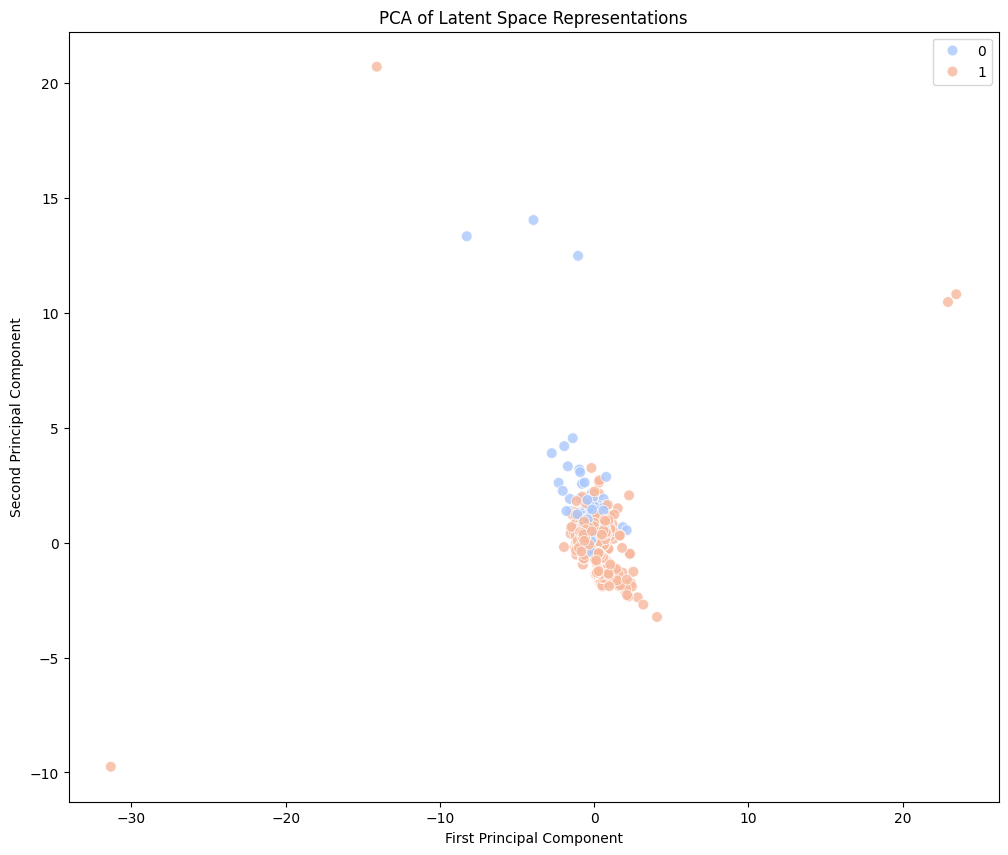

(238,)


In [25]:
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)


def visualize_latent_space_pca(latent_representations, labels, model, device):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(12, 10))
    #scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='plasma', s=10)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title('PCA of Latent Space Representations')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

train_latent, train_labels_np = get_latent_representations(best_model, train_loader, device)
val_latent, val_labels_np = get_latent_representations(best_model, val_loader, device)
visualize_latent_space_pca(val_latent, val_labels_np, best_model, device)

print(val_labels_np[val_labels_np == 0].shape)

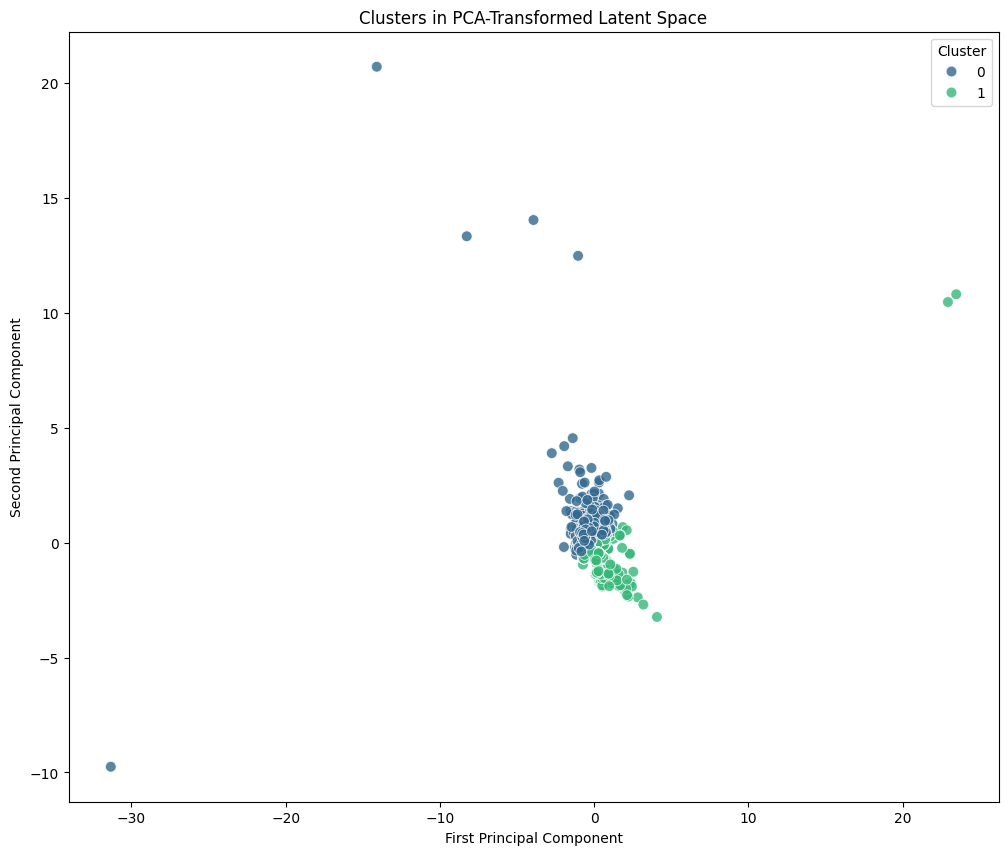

Silhouette Score: 0.39223769307136536
Adjusted Rand Index (ARI): -0.0014352147919665008


In [26]:
def cluster_and_visualize(latent_representations, labels):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    n_clusters = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_2d)
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=cluster_labels, palette='viridis', s=60, alpha=0.8)
    plt.title('Clusters in PCA-Transformed Latent Space')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(title="Cluster")
    plt.show()

    silhouette = silhouette_score(latent_2d, cluster_labels)
    print(f"Silhouette Score: {silhouette}")

    ari = adjusted_rand_score(labels, cluster_labels)
    print(f"Adjusted Rand Index (ARI): {ari}")

cluster_and_visualize(val_latent, val_labels_np)

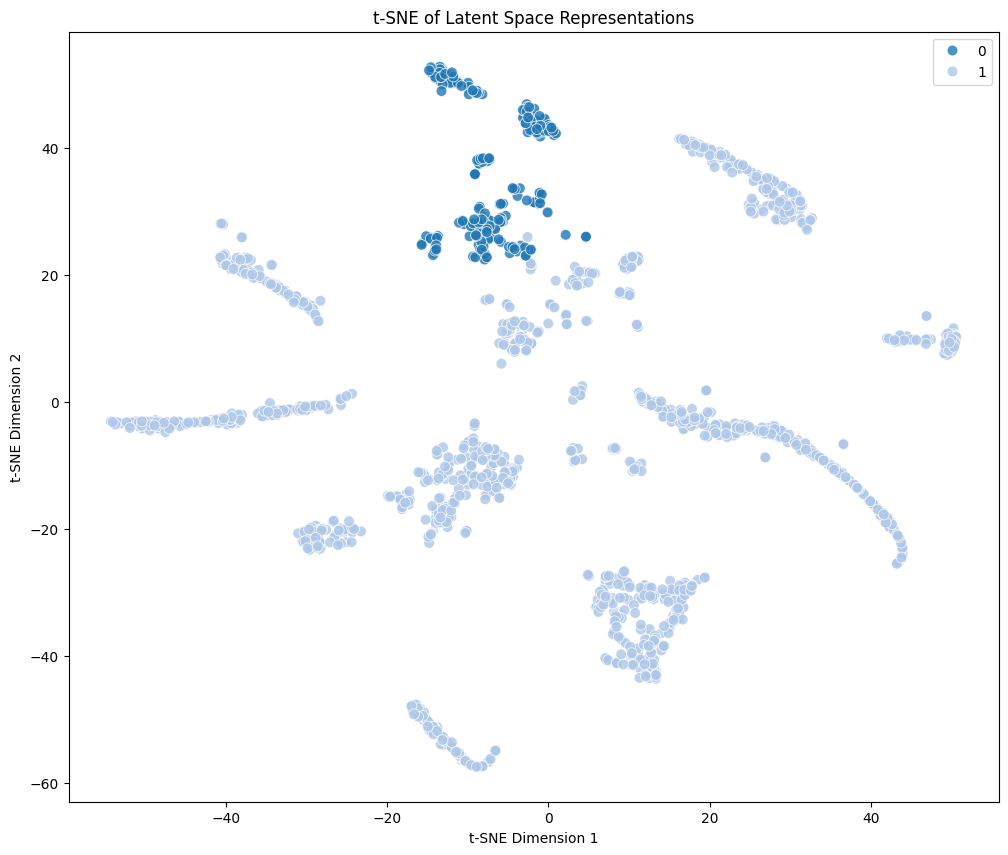

In [27]:
def visualize_latent_space_tsne(latent_representations, labels):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)
    
    palette = sns.color_palette('Spectral', n_colors=len(set(labels)))
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='tab20', s=60, alpha=0.8)
    plt.title('t-SNE of Latent Space Representations')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

visualize_latent_space_tsne(val_latent, val_labels_np)

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


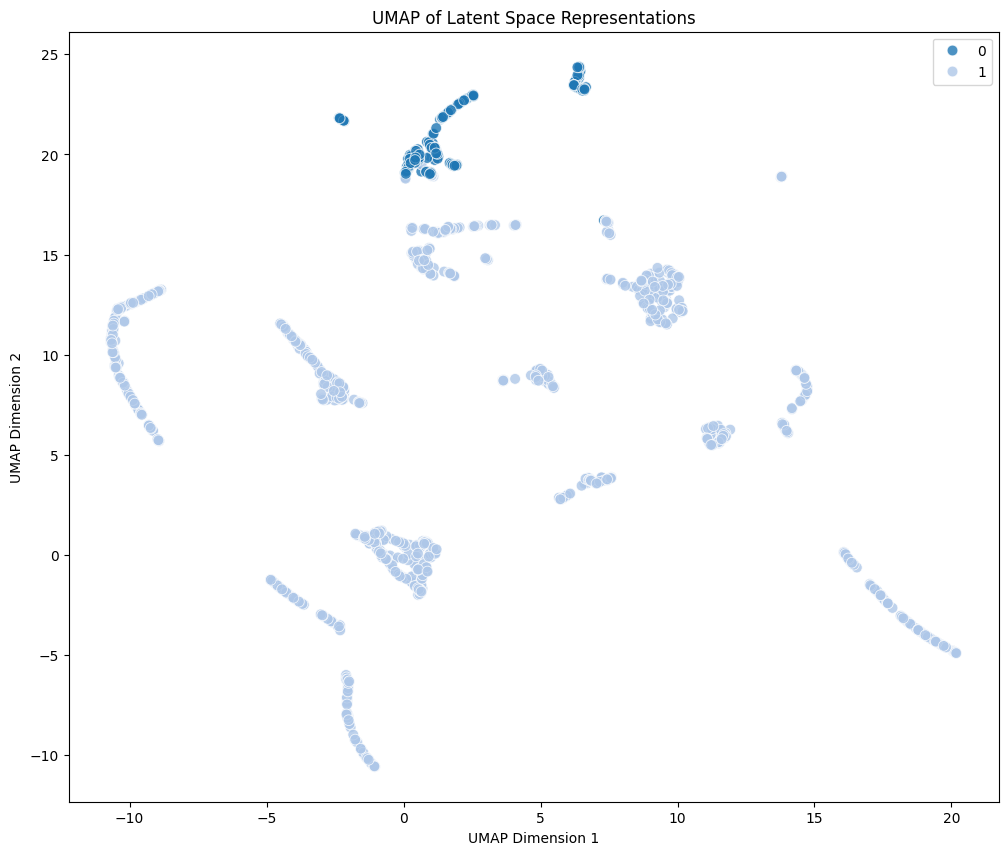

In [23]:
import umap

def visualize_latent_space_umap(latent_representations, labels):
    reducer = umap.UMAP(n_components=2, random_state=42)
    latent_2d = reducer.fit_transform(latent_representations)
    
    palette = sns.color_palette('tab20', n_colors=len(set(labels)))
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette=palette, s=60, alpha=0.8)
    plt.title('UMAP of Latent Space Representations')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

visualize_latent_space_umap(val_latent, val_labels_np)

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr

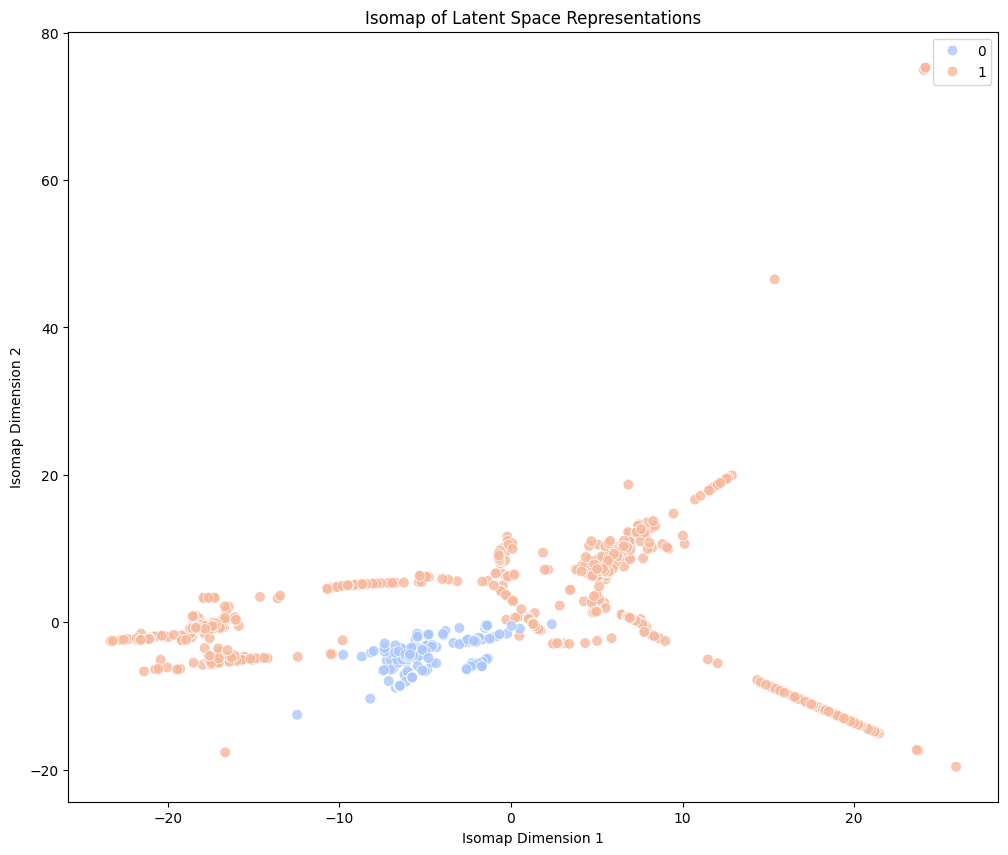

In [24]:
from sklearn.manifold import Isomap

def visualize_latent_space_isomap(latent_representations, labels):
    isomap = Isomap(n_components=2)
    latent_2d = isomap.fit_transform(latent_representations)
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title('Isomap of Latent Space Representations')
    plt.xlabel('Isomap Dimension 1')
    plt.ylabel('Isomap Dimension 2')
    plt.show()

visualize_latent_space_isomap(val_latent, val_labels_np)

In [47]:
from sklearn.metrics import mutual_info_score

def mutual_information(latent_representations, labels):
    mi = mutual_info_score(labels, np.argmax(latent_representations, axis=1))
    print(f"Mutual Information between Latent Variables and Labels: {mi}")

mutual_information(val_latent, val_labels_np)

Mutual Information between Latent Variables and Labels: 0.18794861034057375


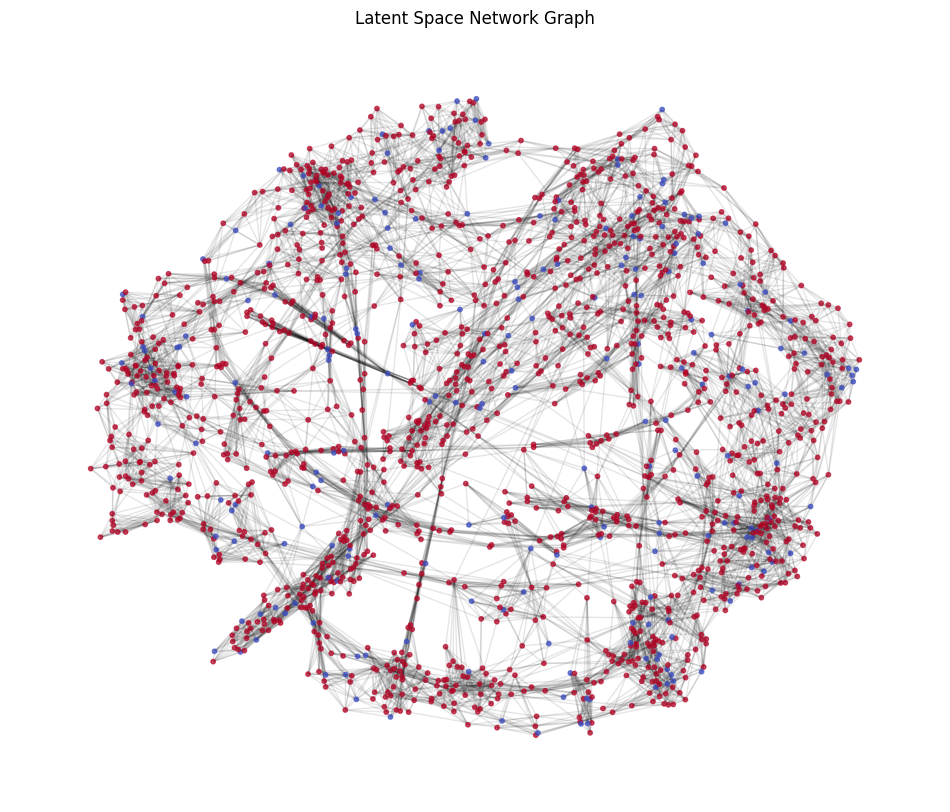

In [26]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

def network_analysis(latent_representations, labels, n_neighbors=10):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(latent_representations)
    distances, indices = nbrs.kneighbors(latent_representations)
    
    G = nx.Graph()
    for i in range(len(latent_representations)):
        for j in indices[i]:
            if i != j:
                G.add_edge(i, j)
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.1)
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color=labels, cmap='coolwarm', alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.1)
    plt.title('Latent Space Network Graph')
    plt.axis('off')
    plt.show()

network_analysis(val_latent, val_labels_np)

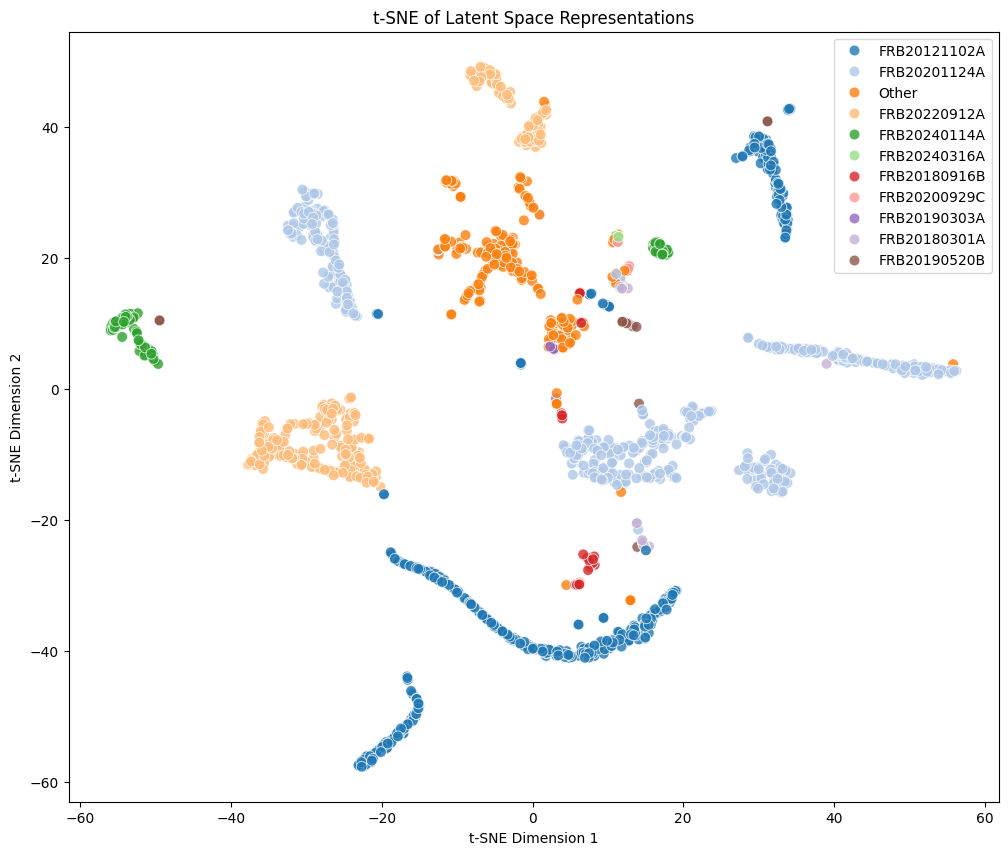

In [49]:
visualize_latent_space_tsne(val_latent, get_source_data_val_freq(10))

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



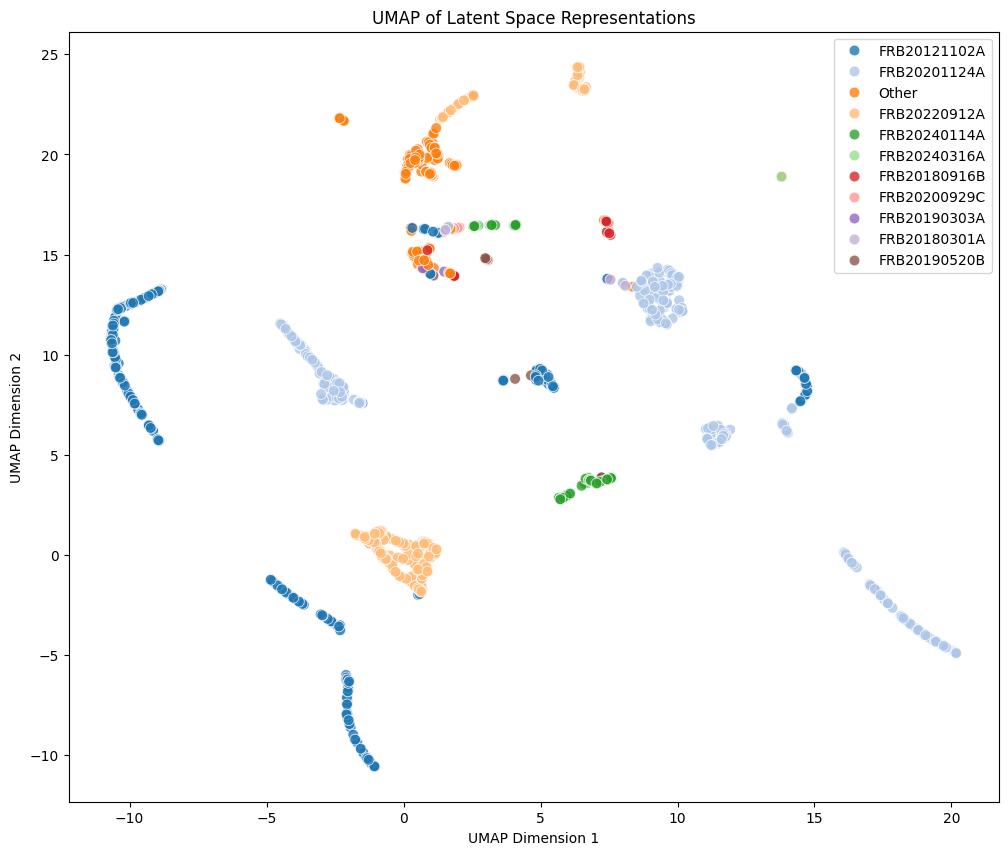

In [50]:
visualize_latent_space_umap(val_latent, get_source_data_val_freq(10))

In [51]:
def visualize_latent_space_tsne_interactive(latent_representations, labels):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    tsne_df = pd.DataFrame({
        'TSNE-1': latent_2d[:, 0],
        'TSNE-2': latent_2d[:, 1],
        'Label': labels
    })

    fig = px.scatter(
        tsne_df, 
        x='TSNE-1', 
        y='TSNE-2', 
        color='Label', 
        hover_data=['Label'], 
        title='Interactive t-SNE of Latent Space Representations',
        width=800,
        height=800
    )

    fig.show()

visualize_latent_space_tsne_interactive(val_latent, get_source_data_val_freq(10))